In [325]:
import numpy as np
import rqcopt as oc
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# get the setup for the problem
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N, gamma = 2, 4, 1
tau = 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma)
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

tol = 1e-12

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=tol)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=tol)

In [3]:
# NOTE: Everything is real so the norm of the imaginary part is completely zero for the gradient and the Xi themselves
for op in [exp_Lvec, exp_Lvec_odd, exp_Lvec_even]:
    print(np.linalg.norm(op.imag))

0.0
0.0
0.0


In [263]:
# we have to start working with X that are (out, k, in) instead of (out, in, k)
# first step: get the k for each layer.
k1 = np.linalg.matrix_rank(X1)
k2 = np.linalg.matrix_rank(X2)

def split_matrix_svd(A, chi_max=2, eps=1e-9):
    """
    Split a matrix by singular value decomposition,
    and truncate small singular values based on tolerance.
    """
    assert A.ndim == 2
    u, s, v = np.linalg.svd(A, full_matrices=False)
    # truncate small singular values
    chi_keep = min(chi_max, np.sum(s > eps))
    assert chi_keep >=1

    idx_keep = np.argsort(s)[::-1][:chi_keep]  # keep the largest `chivC` singular values

    u = u[:, idx_keep]
    v = v[idx_keep, :]
    s = s[idx_keep]
    return u, s, v


def factorize_psd_truncated(psd, chi_max=2, eps=1e-9):
    "factorize psd matrix truncating the singular values based on parameters"
    x, s, xdg = split_matrix_svd(psd, chi_max, eps)
    return x@np.diag(np.sqrt(s))


xs_truncated = []
for X, op in zip([X1,X2], [exp_Lvec_odd, exp_Lvec_even]):
    k = np.linalg.matrix_rank(X)
    x_truncated = factorize_psd_truncated(psd=super2choi(op), chi_max=k)
    C_trnc = x_truncated@x_truncated.conj().T
    print(np.allclose(C_trnc, X@X.conj().T))
    xs_truncated.append(x_truncated)
x1_truncated, x2_truncated = xs_truncated

True
True


In [270]:
# now we need to transform the matrices X we constructed to match the orthogonality condition 
def choi2ortho(x:np.ndarray):
    "transform the x matrices that factorize a choi matrix into its orthogonal form"
    # reshape the x matrix from (out, in, k) to (out, k, in)
    dim = int(np.sqrt(x.shape[0]))
    k = x.shape[1]
    x = np.reshape(x, [dim, dim, k])
    x = x.swapaxes(1,2).reshape([dim*k, dim])
    return x

for x_truncated in [x1_truncated, x2_truncated]:
    print(x_truncated.shape)
    x_ortho = choi2ortho(x_truncated)
    print(x_ortho.shape)
    print(np.allclose(x_ortho.conj().T@x_ortho, np.eye(dim)))

(256, 4)
(64, 16)
True
(256, 2)
(32, 16)
True


In [326]:
# let's create the gradient and see if we can make it into a matrix

# step 1: create the cost function.
# option 1: as we have done it so far, with superoperators and composing them with @. model ys
# option 2: with choi matrices and the choi composition function. model cs
xi_init = [x1_truncated, x2_truncated, x1_truncated]
from opentn.optimization import frobenius_norm, model_Ys, compute_loss
print(compute_loss(xi=xi_init, loss_fn=frobenius_norm, model=model_Ys, exact=exp_Lvec))
# but f should only accept the list of xi as input, meaning that the exact should be given already.
f = lambda xi: frobenius_norm(model_Ys(xi), exp_Lvec)
print(f(xi_init))
# we leave the retraction for later. For now let's focus on the gradient and hessian.
# get the euclidean gradient using jax

from opentn.transformations import vectorize

# the riemannian gradient is obtained projecting to tangent space. 
def project(X, Z):
    "project Z vector onto tangent space at X on manifold"
    return Z - 0.5 * X @ (X.conj().T @ Z + Z.conj().T @ X)

def rgrad_f(xi, func):
    "compute riemannian gradient for all xi, returning a list"
    Zi = jax.grad(func)(xi)
    return [project(X, Z)
    for X,Z in zip(xi, Zi)]

def rgrad_f_vec(xi, func):
    "compute the vectorized gradient for all xi"
    return jnp.vstack([
            vectorize(grad) 
    for grad in rgrad_f(xi, func)]).reshape(-1)

print(rgrad_f_vec(xi_init, f).shape)

# now it is the hessian which remains a question. Let us just create the directed matrix as I think it should be, and then we see if it works
def metric(delta1, delta2, X):
    """
    riemannian metric between delta1 and delta2 in tangent space at X in manifold. 
    From https://arxiv.org/abs/2112.05176 eq. 24
    """
    dim = X.shape[0]
    gamma = np.eye(dim) - 0.5 * (X@X.conj().T)
    return np.trace(delta1.conj().T@gamma@delta2).real

def hvp(xi, v):
    "from https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#hessian-vector-products-with-grad-of-grad"
    return project(
        jax.grad(lambda xi: metric(rgrad_f(xi), v, x))(xi[0]),
        x[0])



# v = np.zeros_like(xi_init[0].reshape(-1))
# v[0] = 1
# v = v.reshape(xi_init[0].shape)
# hvp(xi_init, v=v)

0.09591767023235143
0.09591767023235143
(2560,)


In [6]:
# def hessian_riem(xi):
#     primals, f_vjp = jax.jvp(fun=rgrad_f, primals=[xi], tangents=[xi])
#     # for p in primals:
#     #     print(p.shape)
#     hess_xi = [project(X, Z) for X,Z in zip(xi, primals)]
#     return hess_xi

# def hessian_riem_vec(xi):
#     return np.vstack([
#             vectorize(hess) 
#     for hess in hessian_riem(xi)]).reshape(-1)

In [78]:
xi_init_real = [op.real for op in xi_init]
hessians_xi = jax.jacfwd(rgrad_f, holomorphic=False)(xi_init_real) # change holomorphic to False when using real input
# time for complex: 3.26 min, 
# time for real: 59.3 s

In [79]:
for op in xi_init:
    print(op.shape)
print('Grad')
for op in rgrad_f(xi_init):
    print(op.shape)

(256, 4)
(256, 2)
(256, 4)
Grad
(256, 4)
(256, 2)
(256, 4)


In [163]:
# print(len(hessians_xi))
# for element in hessians_xi:
#     print(len(element))

# lets create a 3x3 array with the dimensions of our elements
shapes_matrix = np.zeros((3,3), dtype=object)
for i, element in enumerate(hessians_xi):
    print('row:', i)
    for j, op in enumerate(element):
        print('column', j)
        print(op.shape)
        shapes_matrix[i,j] = op.shape
    print('----')
# I think the output goes like a Jacobian matrix exactly.
print(shapes_matrix)

row: 0
column 0
(256, 4, 256, 4)
column 1
(256, 4, 256, 2)
column 2
(256, 4, 256, 4)
----
row: 1
column 0
(256, 2, 256, 4)
column 1
(256, 2, 256, 2)
column 2
(256, 2, 256, 4)
----
row: 2
column 0
(256, 4, 256, 4)
column 1
(256, 4, 256, 2)
column 2
(256, 4, 256, 4)
----
[[(256, 4, 256, 4) (256, 4, 256, 2) (256, 4, 256, 4)]
 [(256, 2, 256, 4) (256, 2, 256, 2) (256, 2, 256, 4)]
 [(256, 4, 256, 4) (256, 4, 256, 2) (256, 4, 256, 4)]]


In [169]:
# from the shapes_matrix we can see that each column has different number of elements
for column in shapes_matrix.T:
    print(np.sum([np.prod(element) for element in column]))

2621440
1310720
2621440


In [ ]:
# the question is here also: what would the size of the final array be.
# in the case of RCOPT they have (n1,16,n2,16)
# but that makes sense when fixing n1 and n2, we get an entry of the hessian.
# each of these entries would have (16,16) dimension, which comes from the (out_dim, input_dim) vectorized: vec(4x4)
# in our case (for example) for n1=n2=0 we have:
# out_dim = vec(256x4) = in_dim -> (1024, 1024)
# but for example n1=1, n2=0: (row 1 column 0)
# out_dim = vec(256x2), in_dim = (256x4) -> (512, 1024)
# so you see the problem? fixing n in these cases doesn't result if arrays of the same shape.
# option 1:
# padd zeros to make them homogeneous
# option 2:
# make them the same size from the very beginnning.
# option 3:
# can I make it work even with different sizes?
# most likely not, because of what I just saw on the previous test, each column has different size, so how would you make it a 4d-array like this.
# lets just have a higher rank for the second for now then.


In [86]:
xi_init_real_stack = np.hstack(xi_init_real)
xi_init_real_stack.shape # this does not help really

(256, 10)

In [120]:
# lets use jvp instead

unit_matrices = []
for i, op in enumerate(xi_init_real):
    tangent_vector = np.zeros_like(op)
    tangent_vector[0,0] = 1 
    unit_matrices.append(tangent_vector)
f_eval, jvp_eval = jax.jvp(rgrad_f, (xi_init_real,), ([tangent_vector, np.zeros_like(xi_init_real[1]), np.zeros_like(xi_init_real[2])],)) # first is evaluation of f,  
[op.shape for op in jvp_eval]

[(256, 4), (256, 2), (256, 4)]

In [105]:
hessians_xi[0][0][0,:,:,0].shape, hessians_xi[0][0][:,0,0,:].shape

((4, 256), (256, 4))

In [154]:
 # roll does work as expected even for matrices, its amazing
jnp.roll(tangent_vector, -1)

DeviceArray([[0., 0., 0., 0.],
             [0., 0., 0., 0.],
             [0., 0., 0., 0.],
             ...,
             [0., 0., 0., 0.],
             [0., 0., 0., 0.],
             [0., 0., 0., 1.]], dtype=float64)

In [125]:
_, jvp_eval_test = jax.jvp(rgrad_f, (xi_init_real,), ([jnp.roll(unit_matrices[0], 0), np.zeros_like(xi_init_real[1]), np.zeros_like(xi_init_real[2])],)) # first is evaluation of f,  
jnp.allclose(hessians_xi[0][0][:,:,0,0], jvp_eval_test[0])

DeviceArray(True, dtype=bool)

In [123]:
# my guess: we have the second row, first column of the X2:X1
jnp.allclose(hessians_xi[1][0][:,:,0,0], jvp_eval_test[1]) 

DeviceArray(True, dtype=bool)

In [126]:
jnp.allclose(hessians_xi[2][0][:,:,0,0], jvp_eval_test[2]) 

DeviceArray(True, dtype=bool)

In [146]:
hessians_xi[0][1][:,:,:,5] == hessians_xi[0][1][:,:,:,2]

DeviceArray([[[ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True]],

             [[ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True]],

             [[ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True]],

             ...,

             [[ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  

In [153]:
_, jvp_eval_test = jax.jvp(rgrad_f, (xi_init_real,), ([np.zeros_like(xi_init_real[0]), jnp.roll(unit_matrices[1], 2), np.zeros_like(xi_init_real[2])],)) # first is evaluation of f,  
jnp.allclose(hessians_xi[0][1][:,:,1,0], jvp_eval_test[0]), jnp.allclose(hessians_xi[1][1][:,:,1,0], jvp_eval_test[1]), jnp.allclose(hessians_xi[2][1][:,:,1,0], jvp_eval_test[2])

(DeviceArray(True, dtype=bool),
 DeviceArray(True, dtype=bool),
 DeviceArray(True, dtype=bool))

In [113]:
print('1')
for i in range(256):
    for j in range(4):
                if jnp.allclose(hessians_xi[0][0][i,j,:,:], jvp_eval[0]):
                    print(i, j)
                    print(True)

print('2')
for i in range(256):
    for j in range(4):
                if jnp.allclose(hessians_xi[0][0][:,:,i,j], jvp_eval[0]):
                    print(i, j)
                    print(True)
print('3')
for i in range(256):
    for j in range(4):
                if jnp.allclose(hessians_xi[0][0][i,:,:,j].T, jvp_eval[0]):
                    print(i, j)
                    print(True)
print('4')
for i in range(256):
    for j in range(4):
                if jnp.allclose(hessians_xi[0][0][:,j,i,:], jvp_eval[0]):
                    print(i, j)
                    print(True)

1
2
0 0
True
3
4


In [155]:
xi_init_real[0].size

1024

In [374]:
# now I here will generate a function that projects each element as we generate them
# unit_matrices is used with rolling

from scipy.linalg import fractional_matrix_power

def get_unit_matrices(ops):
    unit_matrices = []
    for op in ops:
        # TODO: change dtype here if I want things to be complex. Right now it is just casting it (discarding real part)
        tangent_vector = np.zeros_like(op)
        tangent_vector[0,0] = 1 
        unit_matrices.append(tangent_vector)
    return unit_matrices


def riemannian_hessian(func, x, vector=False):
    "get riemannian hessian of func (needs to be the gradient of the actual function) evaluated at x"
    n = len(x)
    assert n == 3, 'wrong input size'
    unit_matrices = get_unit_matrices(x)
    hessian_columns = []

    for i in range(n):
        print('column :',i)
        dxk_size = x[i].size
        if vector:
            xi_dxk = [np.zeros((op.size, dxk_size)) for op in x]
        else:
            xi_dxk = [np.zeros(op.shape + (dxk_size,)) for op in x]
        
        for k in range(dxk_size):
            # printing every 100 steps to see progress
            # if k%100 == 0:
                # print('element: ', k)
            _, jvp_eval = jax.jvp(func, (x,), ([jnp.zeros_like(op) if l!=i else jnp.roll(unit_matrices[l],k) for l,op in enumerate(x)],))

            for j, element in enumerate(jvp_eval):
                # we need to project each of them and store in an array that has information about the index k
                if vector:                    
                    xi_dxk[j][:,k] += project(x[j],element).reshape(-1)
                else:
                    xi_dxk[j][:,:,k] += project(x[j],element)
        hessian_columns.append(xi_dxk)
    return hessian_columns


def riemannian_hessian_vec(func, x):
    "TODO: complete this function. seems the 'only' thing missing"
    hessian_columns = riemannian_hessian(func, x, vector=True) 
    # need to reshape each element on the hessian matrix
    # I can do that directly on that hessian matrix function
    # then need to stack them and make sure to have 3, size, 3, size
    # because im not sure what shape I would get of just stacking them
    # i can check with just a simple example. tomorrow
    n = len(x)
    size_vec = hessian_columns[0][0].shape[0]

    hessian_full = np.stack(hessian_columns, axis=1) # n, n, size_vec, size_vec
    hessian_full = hessian_full.swapaxes(1,2).reshape(n*size_vec, n*size_vec)
    return hessian_full

def polar_decomposition_stiefel(X, Z):
    "from equation 4.7 of https://assets.press.princeton.edu/chapters/absil/Absil_Chap4.pdf"
    assert X.shape == Z.shape, "shapes don't match"
    d = X.shape[1]
    return (X+Z)@fractional_matrix_power(np.eye(d) + Z.conj().T@Z, -0.5)


def retract_x(x_list, eta):
    "retraction from tanget space at x to original manifold of x"
    n = len(x_list)
    # here we have to assume that all x have the same shape 
    eta = np.reshape(eta, ((n,) + x_list[0].shape))
    return [polar_decomposition_stiefel(x_list[j], eta[j]) for j in range(n)]
            


In [366]:
((3,) + xi_init_real[0].shape)

(3, 256, 4)

In [254]:
import scipy
a = np.random.rand(16,16)
a_powered = fractional_matrix_power(a, -0.5)
np.allclose(a_powered, np.linalg.inv(scipy.linalg.sqrtm(a))) # changing the order of sqrt and inverse changes the result

True

In [261]:
a = np.random.rand(4,4)
a_list = [a, a, a]
np.stack([a_list, a_list], axis=1).shape

(3, 2, 4, 4)

In [248]:
xi_dk_test_full = riemannian_hessian(rgrad_f, xi_init_real)

column : 0
element:  0
element:  100
element:  200
element:  300
element:  400
element:  500
element:  600
element:  700
element:  800
element:  900
element:  1000
column : 1
element:  0
element:  100
element:  200
element:  300
element:  400
element:  500
column : 2
element:  0
element:  100
element:  200
element:  300
element:  400
element:  500
element:  600
element:  700
element:  800
element:  900
element:  1000


In [225]:
for op in xi_dk_test_full[2]:
    print(op.shape)

(256, 4, 1024)
(256, 2, 1024)
(256, 4, 1024)


In [180]:
xi_dk_test = riemannian_hessian(rgrad_f, xi_init_real)

element:  0
element:  10
element:  20
element:  30
element:  40
element:  50
element:  60
element:  70
element:  80
element:  90
element:  100
element:  110
element:  120
element:  130
element:  140
element:  150
element:  160
element:  170
element:  180
element:  190
element:  200
element:  210
element:  220
element:  230
element:  240
element:  250
element:  260
element:  270
element:  280
element:  290
element:  300
element:  310
element:  320
element:  330
element:  340
element:  350
element:  360
element:  370
element:  380
element:  390
element:  400
element:  410
element:  420
element:  430
element:  440
element:  450
element:  460
element:  470
element:  480
element:  490
element:  500
element:  510
element:  520
element:  530
element:  540
element:  550
element:  560
element:  570
element:  580
element:  590
element:  600
element:  610
element:  620
element:  630
element:  640
element:  650
element:  660
element:  670
element:  680
element:  690
element:  700
element:  710
ele

In [249]:
for i, op in enumerate(xi_dk_test_full[0]):
    print(jnp.allclose(op, xi_dk_test[i]))

True
True
True


In [181]:
for op in xi_dk_test:
    print(op.shape)

(256, 4, 1024)
(256, 2, 1024)
(256, 4, 1024)


In [375]:
# lets do the actual simulations now with the correct shapes:
# generate the new xs with all the same sizes
from opentn.transformations import choi2ortho, ortho2choi
from opentn.optimization import model_Ys_stiefel

# NOTE: changed now to .real on second element but haven't ran with it.
xs_init_2_real = [x1_truncated.real, factorize_psd_truncated(psd=super2choi(exp_Lvec_even), chi_max=4, eps=1e-15).real ,x1_truncated.real]
# they are all the size (256,4)
# now convert them into the matrices that are actually orthonormal
xs_init_2_ortho = [choi2ortho(op) for op in xs_init_2_real]
print([np.allclose(op.conj().T@op, np.eye(dim)) for op in xs_init_2_ortho])

# now the function needs to accept the orthonormal ones
f_stiefel = lambda xi: frobenius_norm(model_Ys_stiefel(xi), exp_Lvec)
print(f_stiefel(xs_init_2_ortho))

# and we can use our gradient with this function:
grad_stiefel_vec = lambda xi: rgrad_f_vec(xi, f_stiefel)
print(grad_stiefel_vec(xs_init_2_ortho).shape)
# this is the unvectorized one to use with the hessian
grad_stiefel = lambda xi: rgrad_f(xi, f_stiefel)
print([ op.shape for op in grad_stiefel(xs_init_2_ortho)])

# now we construct the riemannian
# hessian_columns = riemannian_hessian(grad_stiefel, xs_init_2_ortho, vectorize=False)
# hessian_full = riemannian_hessian_vec(grad_stiefel, xs_init_2_ortho)
hessian_stiefel = lambda xi: riemannian_hessian_vec(grad_stiefel, xi)
# unit_matrices = get_unit_matrices(xs_init_2_ortho)
# k = 0
# _, jvp_eval = jax.jvp(grad_stiefel, (xs_init_2_ortho,), ([jnp.zeros_like(op) if l!=i else jnp.roll(unit_matrices[l],k) for l,op in enumerate(xs_init_2_ortho)],))
# print(len(jvp_eval))

[True, True, True]
0.09591767023235147
(3072,)
[(64, 16), (64, 16), (64, 16)]


In [357]:
hessian_full.shape

(3072, 3072)

In [342]:
[(column[0]).shape for column in hessian_columns]
# [op.shape for op in hessian_columns]

[(64, 16, 1024), (64, 16, 1024), (64, 16, 1024)]

In [377]:
# lets see if the optimization runs even, its scary but lets try it out at least.
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
xs, f_iter, err_iter = riemannian_trust_region_optimize(
    f_stiefel, retract_x, grad_stiefel_vec, hessian_stiefel, xs_init_2_ortho
)

iteration: 0
column : 0
column : 1
column : 2
iteration: 1
column : 0
column : 1
column : 2
iteration: 2
column : 0
column : 1
column : 2
iteration: 3
column : 0
column : 1
column : 2
iteration: 4
column : 0
column : 1
column : 2
iteration: 5
column : 0
column : 1
column : 2
iteration: 6
column : 0
column : 1
column : 2
iteration: 7
column : 0
column : 1
column : 2
iteration: 8
column : 0
column : 1
column : 2
iteration: 9
column : 0
column : 1
column : 2
iteration: 10
column : 0
column : 1
column : 2
iteration: 11
column : 0
column : 1
column : 2
iteration: 12
column : 0
column : 1
column : 2
iteration: 13
column : 0
column : 1
column : 2
iteration: 14
column : 0
column : 1
column : 2
iteration: 15
column : 0
column : 1
column : 2
iteration: 16
column : 0
column : 1
column : 2
iteration: 17
column : 0
column : 1
column : 2
iteration: 18
column : 0
column : 1
column : 2
iteration: 19
column : 0
column : 1
column : 2


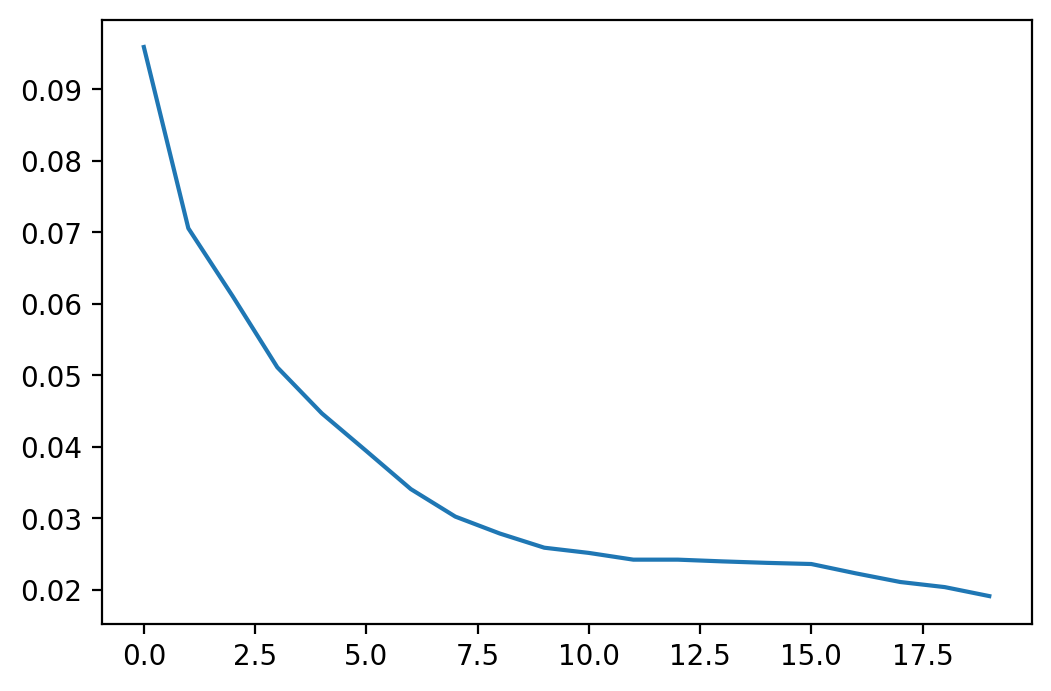

In [380]:
import matplotlib.pyplot as plt

plt.figure(dpi=200)
plt.plot(f_iter)

In [401]:
# I need to check if the matrices are actually isometries
from opentn.stiefel import check_isometry

check_isometry(xs)

[False, False, True]

# TRASH

In [42]:
lambda metric(rgrad_f(xi_init)[0], v, xi_init[0])

-7.311165756268884

In [29]:
grads = jax.grad(f)(xi_init)
metric(grads[0], grads[2], xi_init[0])

1.7305042292865611

In [24]:
# lets concatenate vectors into one long vector
a = np.arange(5).reshape((5,1))
b =  np.arange(3).reshape((3,1))
c = np.arange(2).reshape((2,1))
np.vstack([a,b,c]).reshape(-1)

array([0, 1, 2, 3, 4, 0, 1, 2, 0, 1])

In [ ]:
# from truncated_cg:
# we obtain the z, on_boundary from this function
# inside the function the z has the following pipeline:
# 0. r = grad.copy() / grad = gradfunc(x) on riemannian_trust_region_optimize()
# 1. z = np.zeros_like(r)
# 2. a. z + t*d
#    b. z += alpha * d / d = -r, alpha = rsq / dHd
# with rsq = np.dot(r, r), dHd = np.dot(d, Hd),  Hd = hess @ d
# NOTE: from this we see that gradient is in fact a vector on tangent space and hessian is an operator acting on this space

# how is the freaking hessian built thoguth.

In [ ]:
# lets discect this code

def brickwall_unitary_hessian_matrix(Vlist, L, U, perms):
    """
    Construct the Hessian matrix of Re tr[U† W] with respect to Vlist
    defining the layers of W,
    where W is the brickwall circuit constructed from the gates in Vlist.
    """
    n = len(Vlist)
    H = np.zeros((n, 16, n, 16)) # n being the number of layers, 16 = 4x4 = vectorization of a (4,4) matrix (2-qubit gate)
    for j in range(n):  # going through all the layers
        for k in range(16): # going through all the elements of a single vector
            # unit vector
            Z = np.zeros(16)
            Z[k] = 1 # vector Z_k = [0,...,1,...0] at position k
            Z = real_to_antisymm(np.reshape(Z, (4, 4))) # Z matrix with zero everywhere except at position (i,j) with k = i*4 + j
            # what we pass to this function:
            # Vlist = the list len(n) of V matrix on each layer
            # L = number of sites I think, meaning how many times this V is repeated on each layer
            #  Vlist[j] @ Z = specifically which of the Vs we are passing [j] for the jth layer, **matrix** multiplied by the sort of matrix vector in one of the 16 "directions"
            # j = number of layer
            # U = the unitary we are comparing to
            # perms = I think is whether we use a permutation matrix or not
            # unitary_proj = whether or not to project dVj (gradient at Vlist[j]) onto the tangent space at Vlist[j]
            # return?
            # what I don't understand is the  Vlist[j] @ Z,
            dVZj = brickwall_unitary_hess(Vlist, L, Vlist[j] @ Z, j, U, perms, unitary_proj=True)
            # one column of the hessian
            for i in range(n):
                # here again we are multiplying Vlist[i]+ @ ith matrix of the dVZj column,
                # and is just doing some mapping from antisymmetric to real, which I could in theory do as well,
                # because our matrices are also antisymmetric
                # it returns a matrix of same dimension, and then reshape(-1) vectorizes it
                H[i, :, j, k] = antisymm_to_real(antisymm(Vlist[i].conj().T @ dVZj[i])).reshape(-1) 
    return H.reshape((n * 16, n * 16))

In [ ]:
# in order to know what is the return of the other function we should look at this thing now
# this seems to where we compute the actual hessian, and the other just where we format it, maybe?
def brickwall_unitary_hess(Vlist, L, Z, k, U, perms, unitary_proj=False):
    """
    Compute the Hessian of Re tr[U† W] in direction Z with respect to Vlist[k],
    where W is the brickwall circuit constructed from the gates in Vlist.
    """
    n = len(Vlist) # number of layers in W
    # creating a list of zeros stacking zero matrices of each V in Vlist
    dVlist = np.stack([np.zeros_like(V) for V in Vlist]) # np.stack only works with arrays of same size so this is is the same as just np.stack([np.zeros_like(Vlist[0])]*n)
    # j < k
    for j in range(k):
        # directed gradient with respect to Vlist[j] in direction Z
        UdZk = (  brickwall_unitary(Vlist[j+1:k], L, perms[j+1:k]).conj().T
                @ parallel_gates_directed_grad(Vlist[k], L, Z, perms[k]).conj().T
                @ brickwall_unitary(Vlist[k+1:], L, perms[k+1:]).conj().T
                @ U
                @ brickwall_unitary(Vlist[:j], L, perms[:j]).conj().T)
        # what is the dVj then? look at the function below
        # apparently Compute the gradient of Re tr[U† (V ⊗ ... ⊗ V)] with respect to V (i.e. wrt one of the gates)
        dVj = parallel_gates_grad(Vlist[j], L, UdZk, perms[j]) # this should be one of the "matrices" in one column of the full hessian
        if unitary_proj:
            dVlist[j] += project_unitary_tangent(Vlist[j], dVj)
        else:
            dVlist[j] += dVj

    # Hessian for layer k
    Ueff = (  brickwall_unitary(Vlist[k+1:], L, perms[k+1:]).conj().T
            @ U
            @ brickwall_unitary(Vlist[:k], L, perms[:k]).conj().T)
    dVlist[k] += parallel_gates_hess(Vlist[k], L, Z, Ueff, perms[k], unitary_proj=unitary_proj)

    # so as I understand this is just the way of getting all the possible j=j' and j!=j'.

     # k < j
    for j in range(k + 1, n):
        # directed gradient with respect to Vlist[k] in direction Z
        UdZk = (  brickwall_unitary(Vlist[j+1:], L, perms[j+1:]).conj().T
                @ U
                @ brickwall_unitary(Vlist[:k], L, perms[:k]).conj().T
                @ parallel_gates_directed_grad(Vlist[k], L, Z, perms[k]).conj().T
                @ brickwall_unitary(Vlist[k+1:j], L, perms[k+1:j]).conj().T)
        dVj = parallel_gates_grad(Vlist[j], L, UdZk, perms[j])
        if unitary_proj:
            dVlist[j] += project_unitary_tangent(Vlist[j], dVj)
        else:
            dVlist[j] += dVj

    # it seems to be like if this was the full hessian, but since it is in one certain direction, then is equivalent to one column
    # also based on the shape it seems to the only one column
    return dVlist